In [1]:
import json

json_path = "coco2014/annotations_DCC/captions_split_set_bottle_val_test_novel2014.json"
json_labels = json.load(open(json_path, "r"))
print(json_labels["info"])


{'description': 'This is stable 1.0 version of the 2014 MS COCO dataset.', 'url': 'http://mscoco.org', 'version': '1.0', 'year': 2014, 'contributor': 'Microsoft COCO group', 'date_created': '2015-01-27 09:11:52.357475'}


loading annotations into memory...
Done (t=0.95s)
creating index...
index created!
number of images: 250
[2685, 3595, 4125, 8876, 11742, 13148, 17313, 17409, 23247, 25860, 28209, 30273, 31796, 34811, 37729, 40986, 41110, 44136, 44151, 44165]
{'image_id': 2685, 'id': 568077, 'caption': 'A group of people standing around each other.'}
{'image_id': 2685, 'id': 571854, 'caption': 'A crowd of people stand near a man behind a bar with wine bottles on it.'}
{'image_id': 2685, 'id': 572793, 'caption': 'Many people line up to taste some wine. '}
{'image_id': 2685, 'id': 577428, 'caption': 'a couple of people are standing in front of some wine bottles'}
{'image_id': 2685, 'id': 581967, 'caption': 'The group of people is standing at a wine bar. '}
COCO_val2014_000000002685.jpg


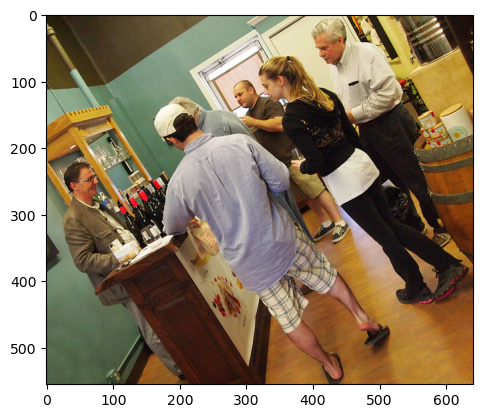

<class 'PIL.Image.Image'>


In [4]:
import os
from pycocotools.coco import COCO
from PIL import Image
import matplotlib.pyplot as plt

img_path = "coco2014/val2014"

# load coco data
coco = COCO(annotation_file=json_path)

# get all image index info
ids = list(sorted(coco.imgs.keys()))
print("number of images: {}".format(len(ids)))
print(ids[0:20])
# get all coco class labels
# coco_classes = dict([(v["id"], v["name"]) for k, v in coco.cats.items()])

img_id = ids[0]
# 获取对应图像id的所有annotations idx信息 一个id 对应5个 annotations
ann_ids = coco.getAnnIds(img_id)
# print(ann_ids)
# 根据annotations idx信息获取所有标注信息
targets = coco.loadAnns(ann_ids)
for target in targets:
    print(target)
# # get image file name


path = coco.loadImgs(img_id)[0]['file_name']
print(path)
# read image
img = Image.open(os.path.join(img_path, path)).convert('RGB')
# draw = ImageDraw.Draw(img)
# # draw box to image
# for target in targets:
#     x, y, w, h = target["bbox"]
#     x1, y1, x2, y2 = x, y, int(x + w), int(y + h)
#     draw.rectangle((x1, y1, x2, y2))
#     draw.text((x1, y1), coco_classes[target["category_id"]])

# show image
plt.imshow(img)
plt.show()
print(type(img))


In [ ]:
from transformers import pipeline

captioner = pipeline("image-to-text",model="microsoft/git-base")
captioner(os.path.join(img_path, path))


## Huggingface Tutorial

In [1]:
from datasets import load_dataset

ds = load_dataset("lambdalabs/pokemon-blip-captions")
ds

/remote-home/pjli/anaconda3/envs/nlptorch/lib/python3.9/site-packages/tqdm/auto.py:21: TqdmWarning: IProgress not found. Please update jupyter and ipywidgets. See https://ipywidgets.readthedocs.io/en/stable/user_install.html
  from .autonotebook import tqdm as notebook_tqdm
Found cached dataset parquet (/remote-home/pjli/.cache/huggingface/datasets/lambdalabs___parquet/lambdalabs--pokemon-blip-captions-10e3527a764857bd/0.0.0/2a3b91fbd88a2c90d1dbbb32b460cf621d31bd5b05b934492fdef7d8d6f236ec)
100%|██████████| 1/1 [00:00<00:00, 222.30it/s]


DatasetDict({
    train: Dataset({
        features: ['image', 'text'],
        num_rows: 833
    })
})

In [2]:
ds = ds["train"].train_test_split(test_size=0.1)
train_ds = ds["train"]
test_ds = ds["test"]
print(train_ds)
print(test_ds)

Dataset({
    features: ['image', 'text'],
    num_rows: 749
})
Dataset({
    features: ['image', 'text'],
    num_rows: 84
})


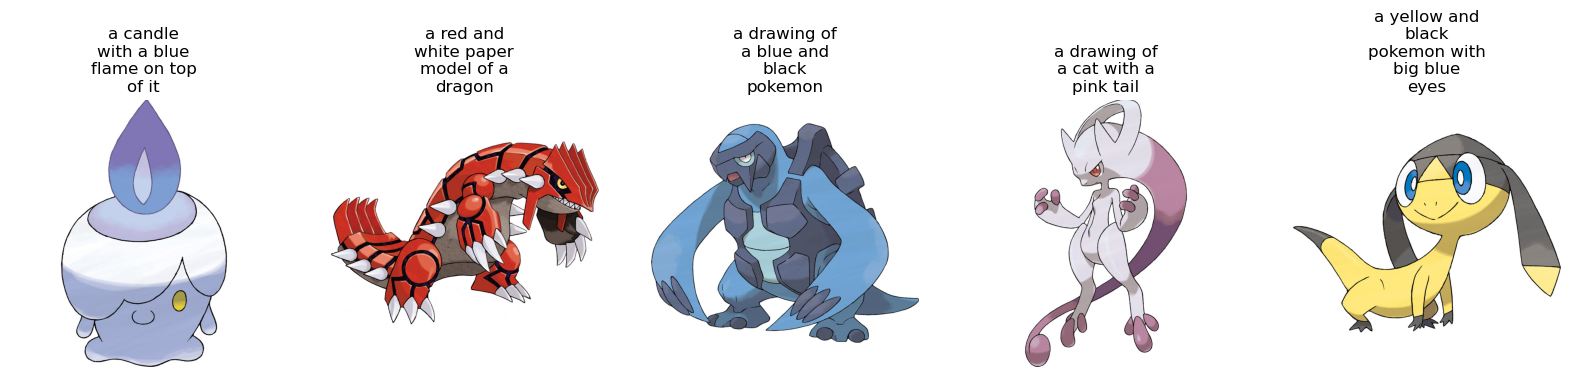

In [3]:
from textwrap import wrap
import matplotlib.pyplot as plt
import numpy as np


def plot_images(images, captions):
    plt.figure(figsize=(20, 20))
    for i in range(len(images)):
        ax = plt.subplot(1, len(images), i + 1)
        caption = captions[i]
        caption = "\n".join(wrap(caption, 12))
        plt.title(caption)
        plt.imshow(images[i])
        plt.axis("off")


sample_images_to_visualize = [np.array(train_ds[i]["image"]) for i in range(5)]
sample_captions = [train_ds[i]["text"] for i in range(5)]
plot_images(sample_images_to_visualize, sample_captions)

In [7]:
from transformers import AutoProcessor, AutoModel
import requests
from PIL import Image
checkpoint = "microsoft/git-base"
processor = AutoProcessor.from_pretrained("microsoft/git-base")


Some weights of the model checkpoint at microsoft/git-base were not used when initializing GitModel: ['output.weight', 'output.bias']
- This IS expected if you are initializing GitModel from the checkpoint of a model trained on another task or with another architecture (e.g. initializing a BertForSequenceClassification model from a BertForPreTraining model).
- This IS NOT expected if you are initializing GitModel from the checkpoint of a model that you expect to be exactly identical (initializing a BertForSequenceClassification model from a BertForSequenceClassification model).


In [5]:
def transforms(example_batch):
    images = [x for x in example_batch["image"]]
    captions = [x for x in example_batch["text"]]
    inputs = processor(images=images, text=captions, padding="max_length")
    inputs.update({"labels": inputs["input_ids"]})
    return inputs


train_ds.set_transform(transforms)
test_ds.set_transform(transforms)

In [8]:
from transformers import AutoModelForCausalLM

model = AutoModelForCausalLM.from_pretrained(checkpoint)

In [9]:
from evaluate import load
import torch

wer = load("wer")


def compute_metrics(eval_pred):
    logits, labels = eval_pred
    predicted = logits.argmax(-1)
    decoded_labels = processor.batch_decode(labels, skip_special_tokens=True)
    decoded_predictions = processor.batch_decode(predicted, skip_special_tokens=True)
    wer_score = wer.compute(predictions=decoded_predictions, references=decoded_labels)
    return {"wer_score": wer_score}

In [10]:
from transformers import TrainingArguments, Trainer

model_name = checkpoint.split("/")[1]

training_args = TrainingArguments(
    output_dir=f"{model_name}-pokemon",
    learning_rate=5e-5,
    num_train_epochs=50,
    fp16=True,
    per_device_train_batch_size=32,
    per_device_eval_batch_size=32,
    gradient_accumulation_steps=2,
    save_total_limit=3,
    evaluation_strategy="steps",
    eval_steps=50,
    save_strategy="steps",
    save_steps=50,
    logging_steps=50,
    remove_unused_columns=False,
    push_to_hub=False,
    label_names=["labels"],
    load_best_model_at_end=True,
)

In [11]:
trainer = Trainer(
    model=model,
    args=training_args,
    train_dataset=train_ds,
    eval_dataset=test_ds,
    compute_metrics=compute_metrics,
)

In [ ]:
trainer.train()

In [17]:
from transformers import pipeline

captioner = pipeline("image-to-text",model="nlpconnect/vit-gpt2-image-captioning")
captioner("coco2014/test2014/COCO_test2014_000000000014.jpg")



Could not find image processor class in the image processor config or the model config. Loading based on pattern matching with the model's feature extractor configuration.


[{'generated_text': 'a man is walking down the street with a skateboard '}]